In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_diabetes, load_iris, make_blobs
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    mutual_info_regression,
    mutual_info_classif)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    adjusted_rand_score,
    mean_absolute_percentage_error,
    accuracy_score,
    precision_score,
    recall_score)
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [138]:
tips = sns.load_dataset('tips')
X = tips.loc[:, ('total_bill', 'tip')]
y = tips.loc[:, ('day')]
tips_lbl = tips.pop('day')

**Esercizio 4.5.1**

In [139]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('kmeans', KMeans(n_init='auto'))
])
y_pred = pipe.fit_predict(X)
print(f'ARI con n_clusters=8: {round(adjusted_rand_score(y, y_pred), 5)}')

pipe.set_params(kmeans__n_clusters=5)
y_pred = pipe.fit_predict(X)
print(f'ARI con n_clusters=5: {round(adjusted_rand_score(y, y_pred), 5)}')

ARI con n_clusters=8: -0.00085
ARI con n_clusters=5: 0.0078


**Esercizio 4.5.2**

In [140]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer())
])

ct = ColumnTransformer(
    [('num_transf', numerical_transformer, ['total_bill', 'tip']),
    ('cat_transf', categorical_transformer, ['sex', 'smoker', 'time'])],
    remainder='drop'
)

complex_pipe = Pipeline([
    ('transformer', ct),
    ('clf', MLPClassifier())
])

complex_pipe.fit(tips, tips_lbl)

c:\Users\acard\.virtualenvs\pcs-exercises-4jw-2ggn\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_transf',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['total_bill', 'tip']),
                                                 ('cat_transf',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['sex', 'smoker', 'time'])])),
                ('clf', MLPClassifier())])

**Esercizio 4.5.3**

In [141]:
param_grid_pipe = {
    'clf__solver': ['lbfgs', 'sgd', 'adam'],
    'clf__learning_rate_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'clf__max_iter': [1000, 2000]
}
search = GridSearchCV(
    complex_pipe,
    param_grid_pipe,
    scoring='accuracy',
    n_jobs=-1,
    cv=10).fit(tips, tips_lbl)

print(f'Migliore accuracy ottenuta: {round(search.best_score_, 2)}')
print(f'Migliori parametri:\n\
      Learning rate: {search.best_params_["clf__learning_rate_init"]}\n\
      Max Iter: {search.best_params_["clf__max_iter"]}\n\
      Solver: {search.best_params_["clf__solver"]}')

Migliore accuracy ottenuta: 0.66
Migliori parametri:
      Learning rate: 0.01
      Max Iter: 2000
      Solver: sgd


**Esercizio 4.5.4**

In [142]:
very_complex_pipe = Pipeline([
    ('transformer', ct),
    ('selector', VarianceThreshold()),
    ('clf', MLPClassifier())
])

complex_search = GridSearchCV(
    very_complex_pipe,
    param_grid_pipe,
    scoring='accuracy',
    n_jobs=-1,
    cv=10).fit(tips, tips_lbl)

print(f'Migliore accuracy ottenuta: {round(complex_search.best_score_, 2)}')
print(f'Migliori parametri:\n\
      Learning rate: {complex_search.best_params_["clf__learning_rate_init"]}\n\
      Max Iter: {complex_search.best_params_["clf__max_iter"]}\n\
      Solver: {complex_search.best_params_["clf__solver"]}')

Migliore accuracy ottenuta: 0.66
Migliori parametri:
      Learning rate: 0.01
      Max Iter: 2000
      Solver: sgd


**Esercizio 4.5.5**

1. Carichiamo il dataset.

In [143]:
data = load_diabetes(as_frame=True)

2. Effettuiamo una semplice analisi esplorativa sul dataset. Ad esempio, possiamo esplorare la distribuzione delle diverse feature.

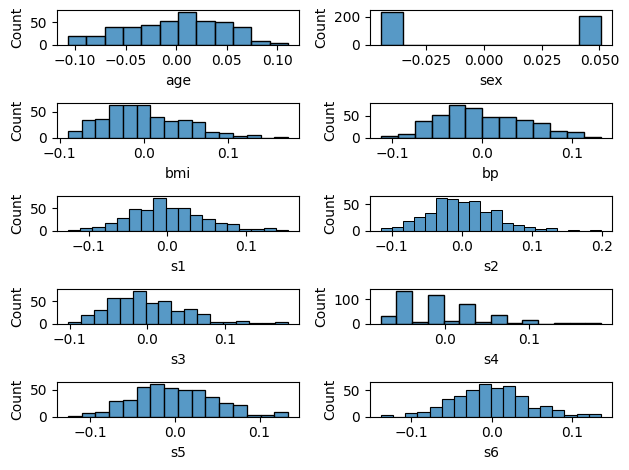

In [144]:
fig, axes = plt.subplots(5, 2)
cols = data.data.columns

for i, ax in zip(cols, axes.flat):
    sns.histplot(data=data.data[i], ax=ax)
plt.tight_layout()
plt.show()

La distribuzione della maggior parte delle feature è di tipo normale. La presenza di valori negativi ci suggerisce inoltre che le feature siano già state normalizzate.

3. Valutiamo adesso la collinearità tra le variabili.

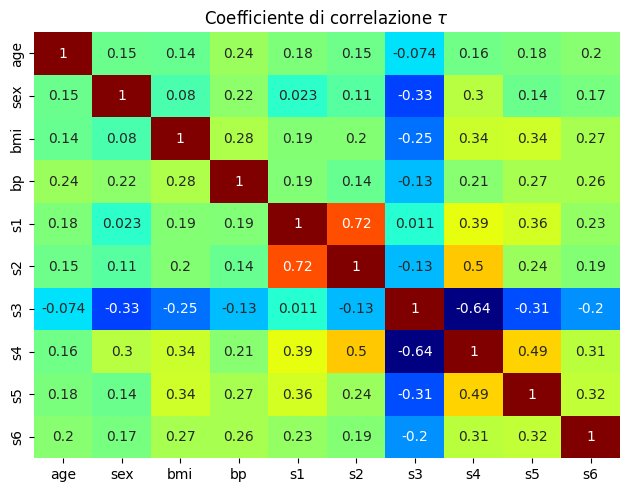

In [145]:
sns.heatmap(
    data.data.corr(method='kendall'),
    annot=True,
    cmap='jet',
    cbar=False)
plt.tight_layout()
plt.title('Coefficiente di correlazione $\\tau$')
plt.show()

Vi è una moderata anticorrelazione tra s2/s3 ed s4, il che è prevedibile dalla descrizione delle feature. Ad ogni modo, non vi è una chiara collinearità.

5. Proviamo ad effettuare una procedura di feature selection mediante `SelectKBest()`.

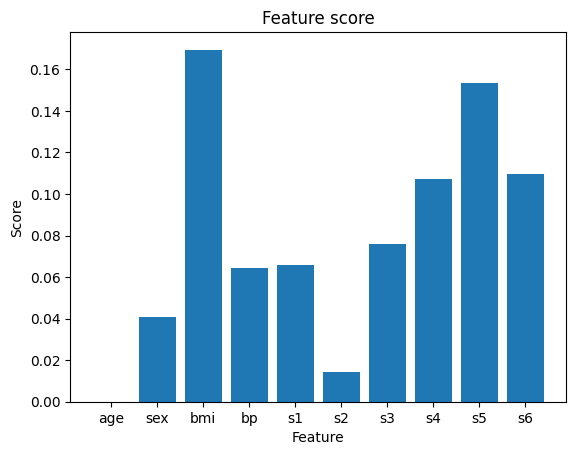

In [146]:
def plot_feat_score(X, y, cols, metric):
    selector = SelectKBest(metric, k=X.shape[-1])
    selector.fit(X, y)
    _, ax = plt.subplots()
    ax.bar(cols, selector.scores_)
    ax.set_title("Feature score")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Score")
    plt.show()

plot_feat_score(
    data.data.values,
    data.target,
    data.data.columns,
    mutual_info_regression)

Notiamo che, tra le diverse feature, quelle relative ad età, genere ed *s2* hanno un punteggio abbastanza basso, per cui un'idea sarebbe quella di scegliere le restanti sette.

In [147]:
selector = SelectKBest(mutual_info_regression, k=7)
X_tr = selector.fit_transform(data.data.values, data.target)

Compariamo il MAPE ottenuto da una regressione lineare e da un albero decisionale.

In [148]:
lr = LinearRegression()
lr.fit(X_tr, data.target)
y_pred = lr.predict(X_tr)
mape_lr = mean_absolute_percentage_error(data.target, y_pred)
dt = DecisionTreeRegressor()
dt.fit(X_tr, data.target)
y_pred = dt.predict(X_tr)
mape_dt = mean_absolute_percentage_error(data.target, y_pred)

print(f'MAPE regressore lineare: {round(mape_lr, 2)}')
print(f'MAPE albero decisionale: {round(mape_dt, 2)}')

MAPE regressore lineare: 0.4
MAPE albero decisionale: 0.0


6. Proviamo ad effettuare una grid search, e vediamo se il MAPE migliora

In [149]:
params = {
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}

gs = GridSearchCV(dt, params, scoring='neg_mean_absolute_percentage_error')
gs.fit(X_tr, data.target)
bdt = gs.best_estimator_
bdt.fit(X_tr, data.target)
y_pred = bdt.predict(X_tr)
mape_bdt = mean_absolute_percentage_error(data.target, y_pred)
print(f'MAPE: {mape_bdt}')
print(f'Migliori parametri: {gs.best_params_}')

MAPE: 0.0
Migliori parametri: {'criterion': 'poisson'}


**Esercizio 4.5.7**

1. Carichiamo il dataset in memoria.

In [150]:
iris = load_iris(as_frame=True)

2. Facciamo una rapida analisi esplorativa.

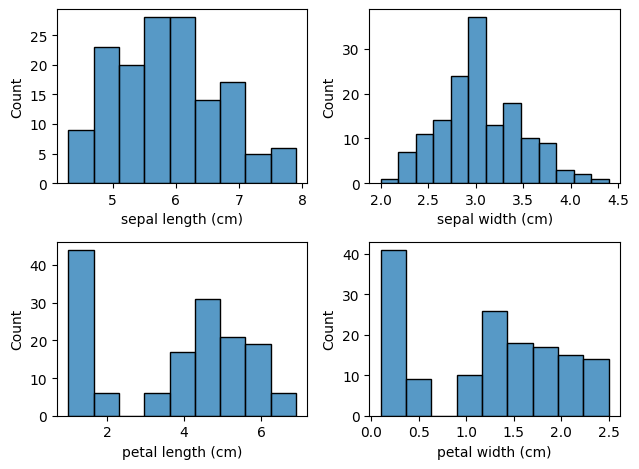

In [151]:
fig, axes = plt.subplots(2, 2)
cols = iris.data.columns

for i, ax in zip(cols, axes.flat):
    sns.histplot(data=iris.data[i], ax=ax)
plt.tight_layout()
plt.show()

Notiamo che le feature relative ai petali non sono distribuite secondo una normale. Ciò implica che, se l'algoritmo lo richiede, dovremo effettuare una standardizzazione dei dati.

3. Valutiamo adesso la collinearità delle feature.

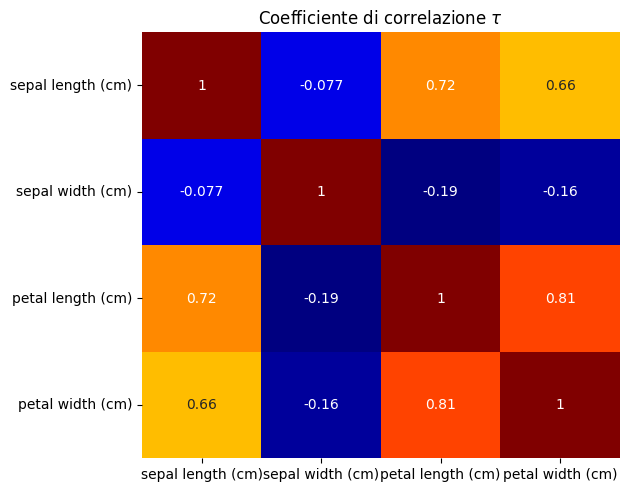

In [152]:
sns.heatmap(
    iris.data.corr(method='kendall'),
    annot=True,
    cmap='jet',
    cbar=False)
plt.tight_layout()
plt.title('Coefficiente di correlazione $\\tau$')
plt.show()

In questo caso esiste una certa collinearità tra le diverse feature, il che ci suggerisce che sia possibile effettuare una procedura di feature selection.

4. Isoliamo le $k$ feature più importanti.

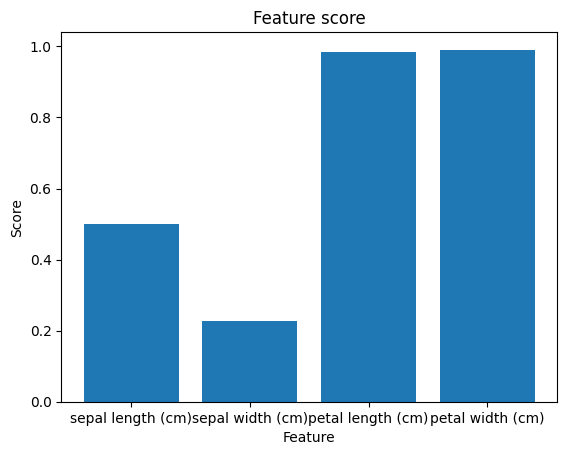

In [153]:
plot_feat_score(
    iris.data.values,
    iris.target,
    iris.data.columns,
    mutual_info_classif)

Dall'analisi della feature importance, emerge che le feature massimamente importanti sono quelle relative alla lunghezza ed alla larghezza dei petali. Proviamo quindi a valutare precisione e recall in diverse situazioni.

5. Compariamo un regressore logistico ed un albero decisionale.

In [154]:
selector = SelectKBest(mutual_info_classif, k=2)
X_tr = selector.fit_transform(
    iris.data.values,
    iris.target)

log = LogisticRegression()
log.fit(X_tr, iris.target)
y_pred = log.predict(X_tr)
pr_log = precision_score(
    iris.target,
    y_pred,
    average='weighted')
rc_log = recall_score(
    iris.target,
    y_pred,
    average='weighted')
print(f'Precisione: {round(pr_log, 2)} - Recall: {round(rc_log, 2)}')

Precisione: 0.97 - Recall: 0.97


In [155]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, iris.target)
y_pred = dt.predict(X_tr)
pr_dt = precision_score(
    iris.target,
    y_pred,
    average='weighted')
rc_dt = recall_score(
    iris.target,
    y_pred,
    average='weighted')
print(f'Precisione: {round(pr_dt, 2)} - Recall: {round(rc_dt, 2)}')

Precisione: 0.99 - Recall: 0.99


6. Usiamo una grid search.

In [156]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss']
}

gs = GridSearchCV(dt, params, scoring='accuracy')
gs.fit(X_tr, iris.target)
bdt = gs.best_estimator_
bdt.fit(X_tr, iris.target)
y_pred = bdt.predict(X_tr)
acc_bdt = accuracy_score(iris.target, y_pred)
print(f'Accuracy: {round(acc_bdt, 2)}')
print(f'Migliori parametri:\nCriterio: {gs.best_params_["criterion"]}')

Accuracy: 0.99
Migliori parametri:
Criterio: gini


**Esercizio 4.5.7**

In [157]:
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

X, y = make_blobs(
    n_samples=1000,
    n_features=100,
    random_state=200,
    cluster_std=[1.8, 2.5, 2.4])

pipe_no_dim_red = Pipeline([
    ('estimator', KMeans(n_init='auto', random_state=42))
])

pipe_dim_red = Pipeline([
    ('dim_red', PCA(n_components=3, random_state=42)),
    ('estimator', KMeans(n_init='auto', random_state=42))
])

preds = pipe_no_dim_red.fit_predict(X)
print(f'ARI senza dimensionality reduction: {round(adjusted_rand_score(y, preds), 2)}')
preds = pipe_dim_red.fit_predict(X)
print(f'ARI con dimensionality reduction: {round(adjusted_rand_score(y, preds), 2)}')

ARI senza dimensionality reduction: 0.46
ARI con dimensionality reduction: 0.46
